In [ ]:
import os
import sys
import numpy as np
from datetime import datetime

import tensorflow as tf
from keras.models import Model
from keras.models import load_model
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, UpSampling2D, Dropout, LeakyReLU, BatchNormalization, Activation, Lambda,MaxPooling2D
from keras.layers.merge import Concatenate
#from keras.applications import VGG16
from keras import backend as K



In [ ]:
from keras.utils import conv_utils
from keras import backend as K
from keras.engine.topology import InputSpec
from keras.layers import Conv2D


class PConv2D(Conv2D):
    def __init__(self, *args, n_channels=3, mono=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_spec = [InputSpec(ndim=4), InputSpec(ndim=4)]

    def build(self, input_shape):        
        """Adapted from original _Conv() layer of Keras        
        param input_shape: list of dimensions for [img, mask]
        """
        
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
            
        if input_shape[0][channel_axis] is None:
            raise ValueError('The channel dimension of the inputs should be defined. Found `None`.')
            
        self.input_dim = input_shape[0][channel_axis]
        
        # Image kernel
        kernel_shape = self.kernel_size + (self.input_dim, self.filters)
        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='img_kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        # Mask kernel
        self.kernel_mask = K.ones(shape=self.kernel_size + (self.input_dim, self.filters))

        # Calculate padding size to achieve zero-padding
        self.pconv_padding = (
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)), 
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)), 
        )

        # Window size - used for normalization
        self.window_size = self.kernel_size[0] * self.kernel_size[1]
        
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.built = True

    def call(self, inputs, mask=None):
        '''
        We will be using the Keras conv2d method, and essentially we have
        to do here is multiply the mask with the input X, before we apply the
        convolutions. For the mask itself, we apply convolutions with all weights
        set to 1.
        Subsequently, we clip mask values to between 0 and 1
        ''' 

        # Both image and mask must be supplied
        if type(inputs) is not list or len(inputs) != 2:
            raise Exception('PartialConvolution2D must be called on a list of two tensors [img, mask]. Instead got: ' + str(inputs))

        # Padding done explicitly so that padding becomes part of the masked partial convolution
        images = K.spatial_2d_padding(inputs[0], self.pconv_padding, self.data_format)
        masks = K.spatial_2d_padding(inputs[1], self.pconv_padding, self.data_format)

        # Apply convolutions to mask
        mask_output = K.conv2d(
            masks, self.kernel_mask, 
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )

        # Apply convolutions to image
        img_output = K.conv2d(
            (images*masks), self.kernel, 
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )        

        # Calculate the mask ratio on each pixel in the output mask
        mask_ratio = self.window_size / (mask_output + 1e-8)

        # Clip output to be between 0 and 1
        mask_output = K.clip(mask_output, 0, 1)

        # Remove ratio values where there are holes
        mask_ratio = mask_ratio * mask_output

        # Normalize iamge output
        img_output = img_output * mask_ratio

        # Apply bias only to the image (if chosen to do so)
        if self.use_bias:
            img_output = K.bias_add(
                img_output,
                self.bias,
                data_format=self.data_format)
        
        # Apply activations on the image
        if self.activation is not None:
            img_output = self.activation(img_output)
            
        return [img_output, mask_output]
    
    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[0][1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0][0],) + tuple(new_space) + (self.filters,)
            return [new_shape, new_shape]
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0], self.filters) + tuple(new_space)
            return [new_shape, new_shape]

In [ ]:
def build_pconv_unet(train_bn=True):      


        img_rows = 128
        img_cols = 128
        # INPUTS
        inputs_img = Input((img_rows, img_cols, 1), name='inputs_img')
        inputs_mask = Input((img_rows, img_cols, 1), name='inputs_mask')
        
        # ENCODER
        def encoder_layer(img_in, mask_in, filters, kernel_size, bn=True):###
            conv, mask = PConv2D(filters, kernel_size, strides=2, padding='same')([img_in, mask_in])
            if bn:
                conv = BatchNormalization(name='EncBN'+str(encoder_layer.counter))(conv, training=train_bn)
            conv = Activation('relu')(conv)
            encoder_layer.counter += 1
            return conv, mask
        encoder_layer.counter = 0
        
        e_conv1, e_mask1 = encoder_layer(inputs_img, inputs_mask, 32, 5, bn=False)
        e_conv5, e_mask5 = encoder_layer(e_conv1, e_mask1, 64, 3)
        e_conv7, e_mask7 = encoder_layer(e_conv5, e_mask5, 128, 3)
        e_conv8, e_mask8 = encoder_layer(e_conv7, e_mask7, 128, 3)

        #model = Model(inputs=[inputs_img, inputs_mask], outputs=[e_conv8, e_mask8])
        
        # DECODER
        def decoder_layer(img_in, mask_in, e_conv, e_mask, filters, kernel_size, bn=True):###
            up_img = UpSampling2D(size=(2,2))(img_in)
            up_mask = UpSampling2D(size=(2,2))(mask_in)
            concat_img = Concatenate(axis=3)([e_conv,up_img])
            concat_mask = Concatenate(axis=3)([e_mask,up_mask])
            conv, mask = PConv2D(filters, kernel_size, padding='same')([concat_img, concat_mask])
            if bn:
                conv = BatchNormalization()(conv)
            conv = LeakyReLU(alpha=0.2)(conv)
            return conv, mask
            
        d_conv9, d_mask9 = decoder_layer(e_conv8, e_mask8, e_conv7, e_mask7, 128, 3)
        d_conv11, d_mask11 = decoder_layer(d_conv9, d_mask9, e_conv5, e_mask5, 64, 3)
        d_conv15, d_mask15 = decoder_layer(d_conv11, d_mask11, e_conv1, e_mask1, 32, 3)
        d_conv16, d_mask16 = decoder_layer(d_conv15, d_mask15, inputs_img, inputs_mask,16, 3, bn=False)
        outputs = Conv2D(1, 3,padding='same', activation = 'sigmoid', name='outputs_img')(d_conv16)
        
        # Setup the model inputs / outputs
        model = Model(inputs=[inputs_img, inputs_mask], outputs=outputs)

        return model, inputs_mask    

In [ ]:
def build_pconv_unet2(train_bn=True):      


        img_rows = 128
        img_cols = 128
        # INPUTS
        inputs_img = Input((img_rows, img_cols, 1), name='inputs_img')
        inputs_mask = Input((img_rows, img_cols, 1), name='inputs_mask')
        
        # ENCODER
        def encoder_layer(img_in, mask_in, filters, kernel_size, bn=True):###
            conv, mask = PConv2D(filters, kernel_size, strides=1, padding='same')([img_in, mask_in])
            conv = MaxPooling2D(pool_size=(2, 2))(conv)
            mask = MaxPooling2D(pool_size=(2, 2))(mask)            
            if bn:
                conv = BatchNormalization(name='EncBN'+str(encoder_layer.counter))(conv, training=train_bn)

            conv = Activation('relu')(conv)
            encoder_layer.counter += 1
            return conv, mask
        encoder_layer.counter = 0
        
        e_conv1, e_mask1 = encoder_layer(inputs_img, inputs_mask, 32, 5, bn=False)
        e_conv5, e_mask5 = encoder_layer(e_conv1, e_mask1, 64, 3)
        e_conv7, e_mask7 = encoder_layer(e_conv5, e_mask5, 128, 3)
        e_conv8, e_mask8 = encoder_layer(e_conv7, e_mask7, 128, 3)

        #model = Model(inputs=[inputs_img, inputs_mask], outputs=[e_conv8, e_mask8])
        
        # DECODER
        def decoder_layer(img_in, mask_in, e_conv, e_mask, filters, kernel_size, bn=True):###
            up_img = UpSampling2D(size=(2,2))(img_in)
            up_mask = UpSampling2D(size=(2,2))(mask_in)
            concat_img = Concatenate(axis=3)([e_conv,up_img])
            concat_mask = Concatenate(axis=3)([e_mask,up_mask])
            conv, mask = PConv2D(filters, kernel_size, padding='same')([concat_img, concat_mask])
            if bn:
                conv = BatchNormalization()(conv)
            conv = LeakyReLU(alpha=0.2)(conv)
            return conv, mask
            
        d_conv9, d_mask9 = decoder_layer(e_conv8, e_mask8, e_conv7, e_mask7, 128, 3)
        d_conv11, d_mask11 = decoder_layer(d_conv9, d_mask9, e_conv5, e_mask5, 64, 3)
        d_conv15, d_mask15 = decoder_layer(d_conv11, d_mask11, e_conv1, e_mask1, 32, 3)
        d_conv16, d_mask16 = decoder_layer(d_conv15, d_mask15, inputs_img, inputs_mask,16, 3, bn=False)
        outputs = Conv2D(1, 3,padding='same', activation = 'sigmoid', name='outputs_img')(d_conv16)
        
        # Setup the model inputs / outputs
        model = Model(inputs=[inputs_img, inputs_mask], outputs=outputs)

        return model, inputs_mask    

In [ ]:
C,D = build_pconv_unet()

In [ ]:
E,F = build_pconv_unet2()

In [ ]:
C.compile(optimizer='adam',loss='binary_crossentropy')
E.compile(optimizer='adam',loss='binary_crossentropy')

In [ ]:
C.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_img (InputLayer)         [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
inputs_mask (InputLayer)        [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
p_conv2d (PConv2D)              [(None, 64, 64, 32), 1632        inputs_img[0][0]                 
                                                                 inputs_mask[0][0]                
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           p_conv2d[0][0]               

In [ ]:
E.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_img (InputLayer)         [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
inputs_mask (InputLayer)        [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
p_conv2d_10 (PConv2D)           [(None, 128, 128, 32 1632        inputs_img[0][0]                 
                                                                 inputs_mask[0][0]                
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 32)   0           p_conv2d_10[0][0]          

In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
#import numpy as np
#X = np.zeros((10000,128,128))

In [ ]:
#import cv2
#for i in range(10000):
#  X[i] = (cv2.resize(x_train[i],(128,128)))

In [ ]:
X.shape

In [ ]:
X[0]

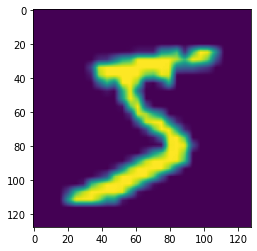

In [ ]:
#plt.imshow(X[0])

In [ ]:
import tensorflow as tf
import cv2  
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
def contour(img):
  img1 = img.copy()
  Gimg = cv2.GaussianBlur(img1,(5,5),1)
  edge = cv2.Canny(Gimg,100,255,3)
  return edge

In [ ]:
x_train_cont = X.copy()
for i in range(X.shape[0]):
  x_train_cont[i] = contour(X[i])

In [ ]:
x_train_cont[0]

In [ ]:
from numpy import loadtxt
Mask = loadtxt('/content/drive/My Drive/Colab Notebooks/mask.csv', delimiter=',')

In [ ]:
X = loadtxt('/content/drive/My Drive/Colab Notebooks/big_xtrain.csv', delimiter=',')
#x_train_cont = loadtxt('/content/drive/My Drive/Colab Notebooks/big_contour.csv', delimiter=',')

In [ ]:
Mask = Mask.reshape(1597,128,128,1)

In [ ]:
X = X.reshape(10000,128,128,1)
#x_train_cont = x_train_cont.reshape(10000,128,128,1)

In [ ]:
X = X.astype('float32') / 255
#x_train_cont = x_train_cont.astype('float32') /255

In [ ]:
#Mask = np.ones((10000,128,128,1))
Mask = Mask.astype('float32')
Mask = np.reshape(Mask, (len(Mask), 128, 128, 1))  

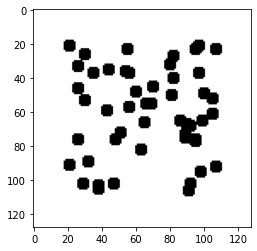

In [ ]:
plt.imshow(Mask[0].reshape(128,128),cmap='gray')

In [ ]:
c = X[0].reshape(128,128)

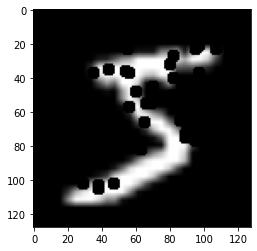

In [ ]:
plt.imshow(c*Mask[0].reshape(128,128),cmap='gray')

In [ ]:
c*(Mask[0].reshape(128,128))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
X.shape

(10000, 128, 128, 1)

In [ ]:
Mask2 = np.ones((10000,128,128,1))
Mask2 = Mask2.astype('float32')
Mask2 = np.reshape(Mask2, (len(Mask2), 128, 128, 1))  

In [ ]:
C.fit([X[:1597],Mask], X[:1597],
                epochs=5,
                batch_size=128,
                shuffle=True)

Epoch 1/5
13/13 [==============================] - 15s 1s/step - loss: 0.1068
Epoch 2/5
13/13 [==============================] - 13s 991ms/step - loss: 0.1001
Epoch 3/5
13/13 [==============================] - 13s 987ms/step - loss: 0.0991
Epoch 4/5
13/13 [==============================] - 13s 987ms/step - loss: 0.0987
Epoch 5/5
13/13 [==============================] - 13s 984ms/step - loss: 0.0986


In [ ]:
E.fit([X[:1597],Mask], X[:1597],
                epochs=5,
                batch_size=128,
                shuffle=True)

Epoch 1/5
13/13 [==============================] - 10s 624ms/step - loss: 0.6884
Epoch 2/5
13/13 [==============================] - 8s 627ms/step - loss: 0.6374
Epoch 3/5
13/13 [==============================] - 8s 630ms/step - loss: 0.4792
Epoch 4/5
13/13 [==============================] - 8s 631ms/step - loss: 0.3281
Epoch 5/5
13/13 [==============================] - 8s 634ms/step - loss: 0.2165


In [ ]:
Mask.shape

(1597, 128, 128, 1)

In [ ]:
ans = C.predict([X[:1597],Mask])

In [ ]:
ans2 = E.predict([X[:1597],Mask])

In [ ]:
Mask[0].shape

(128, 128)

In [ ]:
Mask = Mask.reshape(1597, 128, 128,1)

In [ ]:
ans.shape

(1597, 128, 128, 1)

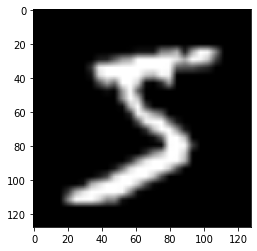

In [ ]:
plt.imshow(X[0].reshape(128,128),cmap='gray')

pretrain過的

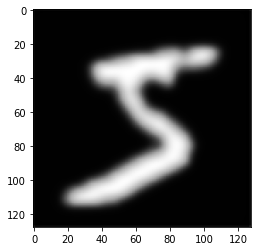

In [ ]:
plt.imshow(ans2[0].reshape(128,128),cmap='gray')

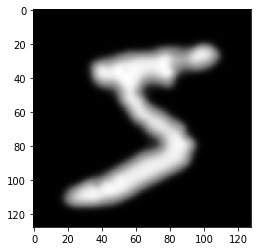

In [ ]:
plt.imshow(ans2[0].reshape(128,128),cmap='gray')

沒pretrain過

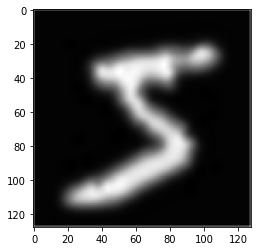

In [ ]:
plt.imshow(ans2[0].reshape(128,128),cmap='gray')

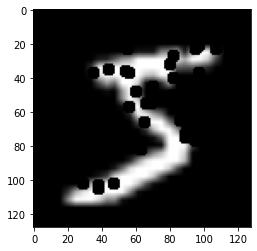

In [ ]:
plt.imshow((X[0].reshape(128,128)*Mask[0].reshape(128,128)),cmap='gray')

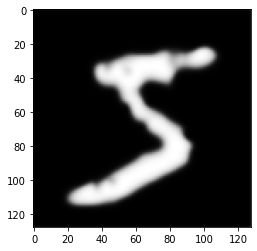

In [ ]:
plt.imshow(ans[0].reshape(128,128),cmap='gray')

In [ ]:
import cv2
import numpy as np
ker = np.ones((3,3),np.uint8)
x_train_cont = x_train_cont.reshape(10000,128,128)
for i in range(10000):
  x_train_cont[i] = cv2.dilate(x_train_cont[i],ker,iterations = 1)

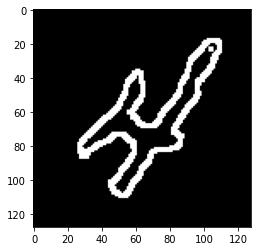

In [ ]:
plt.imshow(x_train_cont[9],cmap='gray')

In [ ]:
x_train_cont[1].shape

(128, 128, 1)

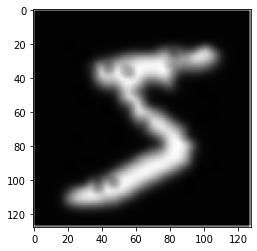

In [ ]:
plt.imshow(ans[0].reshape(128,128),cmap='gray')